##  Predicting Solubility of Molecules

#### 1. Introduction:

Cheminformatics is a branch of chemistry  that utilizes the power of computer and information science technology in conjunction with physical chemistry theory. The "in silico" techniques finds its application in a wide range of descriptive and prescriptive problems in the field of chemistry, including in its applications to biology and related molecular fields. The aqueous solubility is an important property that is assessed in all branches of cheimstry from environmental chemistry, chemical engineering, medicinal chemistry, agrochemistry to analytical chemistry and beyond. 
Prediction of aqueous solubility is a time-consuming experiment and cheminformatics with its allied technologies comes in handy for molecular property prediction.  It is one of the oldest known tasks in cheminformatics.
The aim of this project is to apply machine learning for predicting the solubility of various molecules.



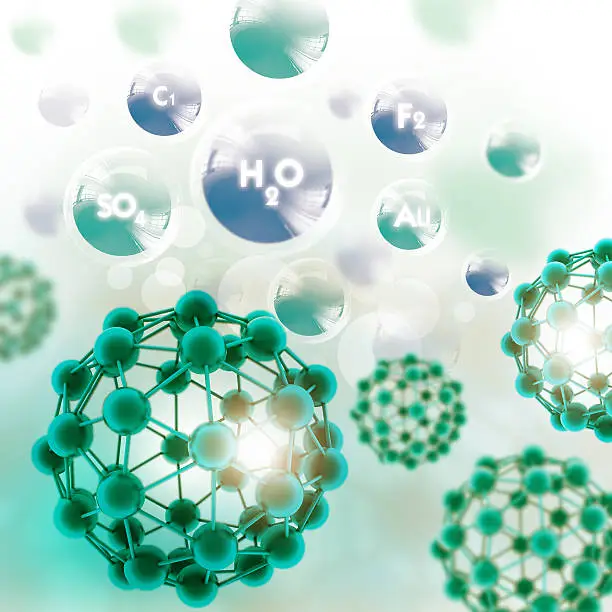

In [1]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "image_solu.webp", width = 1000, height = 1000)

#### 2. Import the Relevant Libraries

In [2]:
import os
import sys
#sys.path.append('../../contrib/torch')
import numpy as np
import pandas as pd
import pubchempy as pcp

In [6]:
import torch
import torch.nn as nn
import deepchem as dc

from torch_geometric.data import Data, Batch
from deepchem.models.torch_models import layers
from deepchem.feat import GraphData
import deepchem.models.torch_models.layers as torch_layers
from deepchem.models.torch_models.dmpnn import _MapperDMPNN
from deepchem.models.torch_models import DMPNN
from deepchem.models.torch_models import DMPNNModel

from typing import Union, List, Sequence, Optional

In [7]:
# from deepchem.molnet.load_function.molnet_loader import TransformerGenerator, _MolnetLoader
# from deepchem.data import Dataset
# from typing import List, Optional, Tuple, Union

In [8]:
#DELANEY_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
#DELANEY_TASKS = ['measured log solubility in mols per litre']

####   3.Description of the Dataset

The dataset for the current project comes from ViridisChem.  A sample dataset for this project comes from the well-known literature work by John S.Delaney(1). The dataset contains  a set of 3818 measured solubilities with data spread acrross 9 different properties.The aquoues solubility(ESOL - Estimate SOLubility) of a compound is estimated directly from its stucture derived from the SMILES column of the dataset.  The other properties listed in the dataset are molecular weight, proportion of heavy atoms in aromatic systems, and a number of rotatable bonds, H-bond donor, acceptor counts, and logP values.

In [9]:
data = pd.read_csv(r"solubility_viridisChem.csv")

#### 4.Exploring the Dataset

In [10]:
data.head()

,ViridisChem_id,pubchem_cid,chemical_name,casrn,property_name,exp_source,exp_reference,exp_value,exp_double_value,exp_units,exp_condition,exp_condition units
0,766,790,hypoxanthine,68940.0,ws,EPI Suite Experimental DB,"YALKOWSKY,SH & DANNENFELSER,RM (1992)",7.00E+02 mg/L at 23 ℃,700.0,mg/L,23,℃
1,2374,2474,Bupivacaine,38396393.0,ws,EPI Suite Experimental DB,"YALKOWSKY,SH & HE,Y (2003)",9.17E+01 mg/L at 23 ℃,91.7,mg/L,23,℃
2,3900,4062,mepivacaine,96888.0,ws,EPI Suite Experimental DB,"YALKOWSKY,SH & DANNENFELSER,RM (1992)",7.00E+03 mg/L at 23 ℃,7000.0,mg/L,23,℃
3,4244,4421,nalidixic acid,389082.0,ws,EPI Suite Experimental DB,MERCK INDEX (1996),1.00E+02 mg/L at 23 ℃,100.0,mg/L,23,℃
4,4463,4649,4-Aminosalicylic acid,65496.0,ws,EPI Suite Experimental DB,"YALKOWSKY,SH & DANNENFELSER,RM (1992)",1.69E+03 mg/L at 23 ℃,1690.0,mg/L,23,℃


In [11]:
data.shape

(3818, 12)

In [12]:
data.columns

Index(['ViridisChem_id', 'pubchem_cid', 'chemical_name', 'casrn',
       'property_name', 'exp_source', 'exp_reference', 'exp_value',
       'exp_double_value', 'exp_units', 'exp_condition',
       'exp_condition units'],
      dtype='object')

In [13]:
data['exp_double_value'].describe()

count    3.818000e+03
mean     8.962423e+04
std      2.673554e+05
min      7.900000e-09
25%      2.000000e+01
50%      8.100000e+02
75%      2.000000e+04
max      6.660000e+06
Name: exp_double_value, dtype: float64

#### 5. Installing PubChempy for further analysis

PubChemPy is a PubChem database written on Python.  The toolkits that it provides are via PUG rest web service.  This service provides an interface for programs to automatically carry out the tasks via the PubChem website.  Retrieving information about a specific coumpoung from its IUPAC, chemical name, SMILES, molecular formula, molecular weight, synonyms are well-establishined command-line tasks. It is also to be noted that a coumpound's cid can be found from it names and vice-versa.

This is important to note there are various properties that can be computed with pubChemPy.  Multiple properties may be specified in a list, or in a comma-separated string. The available properties are: MolecularFormula, MolecularWeight, CanonicalSMILES, IsomericSMILES, InChI, InChIKey, IUPACName, XLogP, ExactMass, MonoisotopicMass, TPSA, Complexity, Charge, HBondDonorCount, HBondAcceptorCount, RotatableBondCount, HeavyAtomCount, IsotopeAtomCount, AtomStereoCount, DefinedAtomStereoCount, UndefinedAtomStereoCount, BondStereoCount, DefinedBondStereoCount, UndefinedBondStereoCount, CovalentUnitCount, Volume3D, XStericQuadrupole3D, YStericQuadrupole3D, ZStericQuadrupole3D, FeatureCount3D, FeatureAcceptorCount3D, FeatureDonorCount3D, FeatureAnionCount3D, FeatureCationCount3D, FeatureRingCount3D, FeatureHydrophobeCount3D, ConformerModelRMSD3D, EffectiveRotorCount3D, ConformerCount3D.

**PubChem Installation and analysis using pubChem is done on a different file for general readability of the program and the notebook.**

#### 6. RDKit Desriptors Extraction

A processed file witht he logarithms of the solubilities, and smiles of the pubchem CIDS were obtained.  The obtained file is fed into RDKit, an open source cheminformatics and machine learning toolkit to getting more detailed values for the descriptors and markers with the inclusion of the SMILES values obtained from Pubchempy registry.  A more detailed intrpdction of RDKit can be found elsewhere.

In [163]:
df = pd.DataFrame(new_smiles)
df.to_csv('smiles_logSol_viridis.csv', header=True, index=False)

In [104]:
import time, csv
import pandas as pd
import rdkit
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [186]:
def extract_descr(data_smiles):
    '''
    Return a list of descriptors for each smiles string
    '''  
    list_of_descr = []
    for mol in data_smiles :       
        print(mol)
        m = Chem.MolFromSmiles(mol)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descr_names)
        each_mol = [i for i in calc.CalcDescriptors(m)]
        each_mol.append(mol[0])
        each_mol.append(mol[1])
        list_of_descr.append(each_mol)
    return list_of_descr

In [190]:
data = pd.read_csv(r"virdis_solu_final.csv")
data['smiles']

0        CCCCN1CCCCC1C(=O)NC2=C(C=CC=C2C)C
1         CC1=C(C(=CC=C1)C)NC(=O)C2CCCCN2C
2      CCN1C=C(C(=O)C2=C1N=C(C=C2)C)C(=O)O
3                  C1=CC(=C(C=C1N)O)C(=O)O
4       CC12CCC(CC1CCC3C2CCC4(C3CCC4=O)C)O
                      ...                 
191                        C(C(=O)O)C(=O)O
192                 C(C(C(=O)O)O)(C(=O)O)O
193                                     CS
194                                     CO
195                     CC(=O)NC1=CC=CC=C1
Name: smiles, Length: 196, dtype: object

In [211]:
import os
import sys
import time, csv
import tempfile

In [192]:
def get_smiles_sol(file_name):
    '''
    Return smiles and experimental solubiliy for each molecule
    '''    
    with open(file_name, 'r') as f:
        csv_reader = csv.reader(f, delimiter = ',')
        next(csv_reader)
        data = [(row[0],float(row[1])) for row in csv_reader]
    
    return data

In [193]:
def extract_descr(data):
    '''
    Return a list of descriptors for each smiles string
    '''  
    list_of_descr = []
    for mol in data:         
        m = Chem.MolFromSmiles(mol[0])
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descr_names)
        each_mol = [i for i in calc.CalcDescriptors(m)]  
        each_mol.append(mol[0])
        each_mol.append(mol[1])
        list_of_descr.append(each_mol)
    
    return list_of_descr

In [194]:
# Getting descriptors names
descr_names = [i[0] for i in Descriptors._descList]

descriptors = extract_descr(get_smiles_sol('virdis_solu_final.csv'))

# Appending 'smiles' and 'sol' to the descriptors names
descr_names.append('smiles')
descr_names.append('sol')

In [195]:
# Writing data to .csv files
def write_to_csv(file_name, data):
    with open(file_name, 'w') as f:
        csv_writer = csv.writer(f, delimiter = ',')
        csv_writer.writerow(descr_names)
        csv_writer.writerows(data)

write_to_csv('rdkit_virdis_solubility.csv', descriptors)

#### 7. DMPNN Implementation

In [199]:
data_rd = pd.read_csv(r"rdkit_virdis_solubility.csv")
data_rd.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,smiles,sol
0,12.692735,12.692735,0.045654,0.045654,0.891013,19.476190,288.435,260.211,288.220164,116,...,0,0,0,0,0,0,1,0,CCCCN1CCCCC1C(=O)NC2=C(C=CC=C2C)C,-3.497626
1,12.329587,12.329587,0.025700,0.025700,0.869904,20.722222,246.354,224.178,246.173213,98,...,0,0,0,0,0,0,0,0,CC1=C(C(=CC=C1)C)NC(=O)C2CCCCN2C,-1.546455
2,11.915193,11.915193,0.217590,-1.208634,0.849524,10.705882,232.239,220.143,232.084792,88,...,0,0,0,0,0,0,0,0,CCN1C=C(C(=O)C2=C1N=C(C=C2)C)C(=O)O,-3.365918
3,10.332243,10.332243,0.139630,-1.164352,0.517606,9.454545,153.137,146.081,153.042593,58,...,0,0,0,0,0,0,0,0,C1=CC(=C(C=C1N)O)C(=O)O,-1.957202
4,12.377281,12.377281,0.012444,-0.054130,0.732973,56.523810,290.447,260.207,290.224580,118,...,0,0,0,0,0,0,0,0,CC12CCC(CC1CCC3C2CCC4(C3CCC4=O)C)O,-4.383815


In [202]:
data_rd['smiles']

0        CCCCN1CCCCC1C(=O)NC2=C(C=CC=C2C)C
1         CC1=C(C(=CC=C1)C)NC(=O)C2CCCCN2C
2      CCN1C=C(C(=O)C2=C1N=C(C=C2)C)C(=O)O
3                  C1=CC(=C(C=C1N)O)C(=O)O
4       CC12CCC(CC1CCC3C2CCC4(C3CCC4=O)C)O
                      ...                 
191                        C(C(=O)O)C(=O)O
192                 C(C(C(=O)O)O)(C(=O)O)O
193                                     CS
194                                     CO
195                     CC(=O)NC1=CC=CC=C1
Name: smiles, Length: 196, dtype: object

In [204]:
data_rd.columns

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole',
       'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'smiles',
       'sol'],
      dtype='object', length=212)

In [206]:
tasks_sol = data_rd['sol']
smiles_sol = data['smiles']

In [207]:
feat = dc.feat.DMPNNFeaturizer()

In [210]:
df = pd.DataFrame(list(zip(data_rd['smiles'], data_rd['sol'])), columns=["smiles_sol", "tasks_sol"])

In [212]:
with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
     df.to_csv(tmpfile.name)
     feat = dc.feat.DMPNNFeaturizer()
     loader = dc.data.CSVLoader(["tasks_sol"], feature_field="smiles_sol", featurizer = feat)
     dataset = loader.create_dataset(tmpfile.name)
len(dataset)

196

In [213]:
model = DMPNNModel()
out = model.fit(dataset, nb_epoch=10)

In [214]:
print(out)

1.1722578684488931
